# Notebook for Data Collection and Sentiment Analysis for post(SBF-FTX) event
Time Duration of Data Collection: (11/08/2022 - 12/31/2022)

Data collected from subreddits: r/FTX_Official and r/CryptoCurrency



In [31]:
pip install praw

### Post collection from required subreddits:

In [32]:
import praw
import pandas as pd
from datetime import datetime, timedelta

reddit = praw.Reddit(client_id='Pkxsdlath__w1PLlz9SqYw',
                     client_secret='SmR27wNNF077_bwTwPdHefJTjkU5Uw',
                     user_agent='test',
                     username='smmtest123',
                     password='smmtest@123')


In [33]:
# Array of required subreddits
subreddits = ['FTX_Official', 'CryptoCurrency']
keywords = ['FTX', 'Crypto', 'btc']
start_date = datetime(2022,11,8)
end_date = datetime(2022, 12, 31)

#Dataframe Initialization
combined_df = pd.DataFrame(columns=['Title', 'Author', 'Score', 'Date', 'Post ID'])

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    posts = subreddit.top(limit=50)

    subreddit_data = []

    for post in posts:
        creation_date = datetime.fromtimestamp(post.created_utc)
        if start_date <= creation_date <= end_date:
            title = post.title
            author = post.author.name if post.author else '[deleted]'
            score = post.score
            created_utc = post.created_utc
            post_id = post.id
            if any(keyword.lower() in title.lower() for keyword in keywords):
                subreddit_data.append([title, author, score, creation_date, post_id])

    subreddit_df = pd.DataFrame(subreddit_data, columns=['Title', 'Author', 'Score', 'Date', 'Post ID'])
#Combining the posts under both the subreddits in one dataframe:
    combined_df = pd.concat([combined_df, subreddit_df], ignore_index=True)

new_df = combined_df.drop(columns=['Post ID'])
new_df.rename(columns={'Title': 'Text'}, inplace=True)



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [5]:
new_df.head(4)

,Text,Author,Score,Date
0,How FTX has ruined my life,ForIranians,137,2022-11-20 23:04:55
1,How is Crypto Not a Scam?,MTGLION,95,2022-11-11 18:41:09
2,My Bank did a Successful Chargeback on my FTX ...,Elderberry8128,75,2022-11-16 21:19:45
3,I too lost a got chunk on FTX.. Really sucks b...,LmBallinRKT,66,2022-11-09 23:59:45


In [35]:
# getting the post ids in an array to provide as an input to fetch the comments data
import numpy as np
post_ids = np.array(combined_df["Post ID"])
post_ids = post_ids[:12]


### Getting the comments under the posts of both subreddits using post ID
creating a dataframe with 250 datapoints containing the comments under the the subreddits:

In [37]:
num_comments = 100

all_data = []


for post_id in post_ids:

    post = reddit.submission(id=post_id)

    comments = post.comments[:num_comments]
    #print(comments)

    data = []

    for comment in comments:
        author = comment.author.name if comment.author else '[deleted]'
        text = comment.body
        date = datetime.utcfromtimestamp(comment.created_utc)
        score = comment.score
        data.append([text, author,score, date])


    all_data.extend(data)

df = pd.DataFrame(all_data, columns=['Text','Author', 'Score', 'Date'])
df.head()


df = df[df['Text'] != '[deleted]']
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] <= datetime(2023, 1, 7)]
df = df.drop(df.index[250:len(df)])

#converting the dataframe to csv file
df.to_csv('reddit_data_post_event.csv', index=False)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [38]:
df.shape

(250, 4)

## 2. Script for sentiment analysis using VADER

In [39]:
pip install vaderSentiment

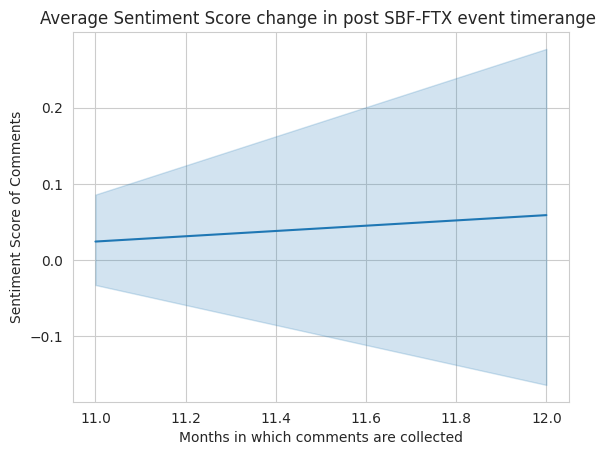

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('reddit_data_post_event.csv')
df = df.loc[:,['Date','Text']]

sid_obj = SentimentIntensityAnalyzer()

# function to pre-precess
def preprocess_data(df):
    df["Text"] = df["Text"].apply(lambda x:x.translate(str.maketrans('','',string.punctuation)))
    df["Date"] = pd.to_datetime(df["Date"])
    df["Month"] = df['Date'].dt.month
    df.to_csv('data.csv', index=False)
    return df

# Compute sentiment and plot monthly score
def sentiment(df):
    sentiment_scores = []
    for Text in df['Text']:
        scores = sid_obj.polarity_scores(Text)
        sentiment_scores.append(scores['compound'])
    df['sentiment_score'] = sentiment_scores

    df_positive = df[df['sentiment_score'] > 0.1]
    #print(df_positive)
    df_negative = df[df['sentiment_score'] < -0.1]
    df_neutral = df[(df['sentiment_score'] >= -0.1) & (df['sentiment_score'] <= 0.1)]

    sns.set_style('whitegrid')
    sns.lineplot(x='Month',y='sentiment_score',data=df).set(title = 'Average Sentiment Score change in post SBF-FTX event timerange ')
    plt.xlabel("Months in which comments are collected")
    plt.ylabel("Sentiment Score of Comments")
    return df, df_positive, df_negative, df_neutral


df = preprocess_data(df)
df,df_positive, df_negative, df_neutral  = sentiment(df)


In [43]:
df_positive.shape, df_negative.shape, df_neutral.shape

((83, 4), (82, 4), (85, 4))

Scatterplot of Comments based on Sentiment Score

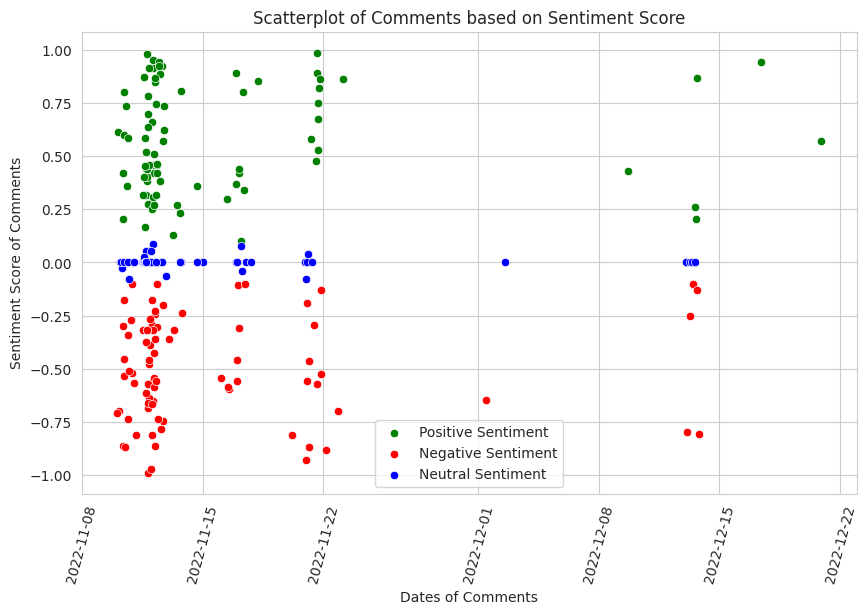

In [45]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# Plot scatter plots for positive, negative, and neutral sentiments
sns.scatterplot(x='Date', y='sentiment_score', data=df_positive, color='green', label='Positive Sentiment')
sns.scatterplot(x='Date', y='sentiment_score', data=df_negative, color='red', label='Negative Sentiment')
sns.scatterplot(x='Date', y='sentiment_score', data=df_neutral, color='blue', label='Neutral Sentiment')

plt.title('Scatterplot of Comments based on Sentiment Score')
plt.xlabel('Dates of Comments')
plt.ylabel('Sentiment Score of Comments')
plt.xticks(rotation=75)
plt.legend()
plt.show()